# **Measure Tuned (Dynamic) DUT and Apply Cal**

### Import modules

In [1]:
import sys
sys.path.append('C:/Users/smithlab/Documents/Aaron/Modules')
import pin_mappings as pm
import numpy as np
import numpy.matlib
import skrf as rf
from skrf.vi.vna import PNA
import matplotlib.pyplot as plt
import calibration_functions as cf
import mainPyDAC2_module as tune
from datetime import date
import time

rf.stylely()

### Load tuning states

In [2]:
# mat = scipy.io.loadmat('Path/to/tuning/states')
# ts = mat['ts'].reshape((96, 50))

# single tuning state
# ts = 2.5*np.ones((240))

# sweep all elements from 0-5 V
ts = numpy.matlib.repmat(np.linspace(0, 5, 50), 240, 1)

# sweep test (161) element from 0-5 V
# ts = np.zeros((240, 50))
# ts[pm.element_pin_index[161 - 1] - 1,:] = np.linspace(0, 5, 51)

### Initialize Arduino

In [3]:
## Arduino
# BAUDRATE, PORTNAME, #DACS
numDACs = 30
tune.setSerial(115200, "COM9", numDACs)
tune.sendInputLen()
msg = tune.receiveFromArduino()

while msg.find("Received: " + str(numDACs) + " from serial.") == -1:
    msg = tune.receiveFromArduino()
    
if not (msg == "NO VAL"):
    print(msg)

READY
Received: 30 from serial.


### Initialize VNA

In [4]:
f_start = 5E9
f_stop = 15E9
f_npoints = int(801)

vna = PNA(address ='TCPIP0::169.254.29.147::hpib7,16::INSTR')
time.sleep(3)
vna.reset()
vna.scpi.set_trigger_manual

meas_channel = 2

meas_S11 = 'S11'
vna.create_meas(meas_S11,'S11', channel = meas_channel) 
meas_S22 = 'S22'
vna.create_meas(meas_S22,'S22', channel = meas_channel) 
meas_S21 = 'S21'
vna.create_meas(meas_S21,'S21', channel = meas_channel) 
meas_S12 = 'S12'
vna.create_meas(meas_S12,'S12', channel = meas_channel) 

vna.set_frequency_sweep(f_start, 
                        f_stop, 
                        f_npoints, 
                        f_unit = 'Hz',
                        channel = meas_channel, 
                        )

### Take measurement

#### *Single tuning state*

In [ ]:
# measurements = []

# tune.testProgram30DAC(ts)
# time.sleep(1)

# vna.sweep

# measurement_S11 = vna.get_measurement(mname = meas_S11)
# measurement_S22 = vna.get_measurement(mname = meas_S22)
# measurement_S21 = vna.get_measurement(mname = meas_S21)
# measurement_S12 = vna.get_measurement(mname = meas_S12)

# measurement = rf.two_port_reflect(measurement_S11, measurement_S22)
# measurement.s[:,0,1] = measurement_S12.s[:,0,0]
# measurement.s[:,1,0] = measurement_S21.s[:,0,0]

# # measurements.append(measurement)
# measurements = measurement

#### *Loop*

In [5]:
measurements = []

for i in range(ts.shape[1]):
    
    tune.testProgram30DAC(ts[:,i])
    time.sleep(0.01)
    
    vna.sweep

    measurement_S11 = vna.get_measurement(mname = meas_S11)
    measurement_S22 = vna.get_measurement(mname = meas_S22)
    measurement_S21 = vna.get_measurement(mname = meas_S21)
    measurement_S12 = vna.get_measurement(mname = meas_S12)

    measurement = rf.two_port_reflect(measurement_S11, measurement_S22)
    measurement.s[:,0,1] = measurement_S12.s[:,0,0]
    measurement.s[:,1,0] = measurement_S21.s[:,0,0]

    measurements.append(measurement)

### Create and apply cal

In [6]:
# cal_folder = 'C:/Users/lab/Documents/Aaron/DARPA/Data/Aaron_Quick_Turn_Antenna/Test_Board_21-10-07/2021-10-07_SOLT/'
cal_folder = 'C:/Users/smithlab/Documents/Aaron/Data/Aaron Quick Turn Antenna/Assembled_Board_1_22-01-27/2022-01-27_TRL_1/'

# cal = cf.make_SOLT_cal(cal_folder)
cal = cf.make_TRL_cal(cal_folder)

measurements_corrected = []

#### Single tuning state
# measurements_corrected = cal.apply_cal(measurements)

for i in range(ts.shape[1]):
    measurements_corrected.append(cal.apply_cal(measurements[i]))

### Plot

(-20.0, 0.0)

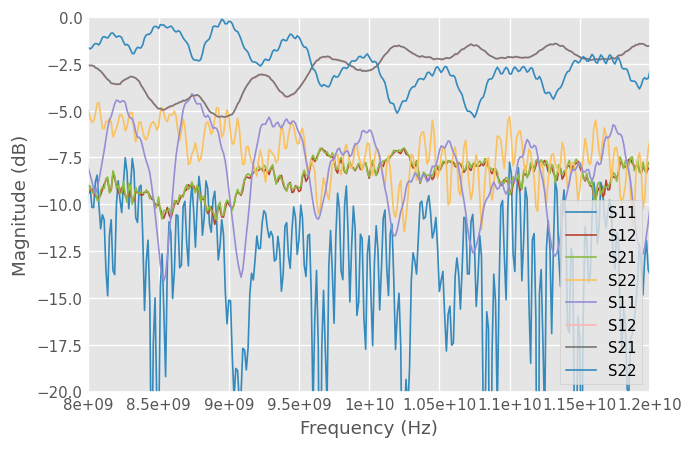

In [7]:
measurements[0].plot_s_db()
measurements_corrected[0].plot_s_db()
plt.xlim(8E9, 12E9)
plt.ylim(-20, 0)

# measurements.plot_s_db()
# measurements_corrected.plot_s_db()
# plt.xlim(8E9, 12E9)
# plt.ylim(-20, 0)

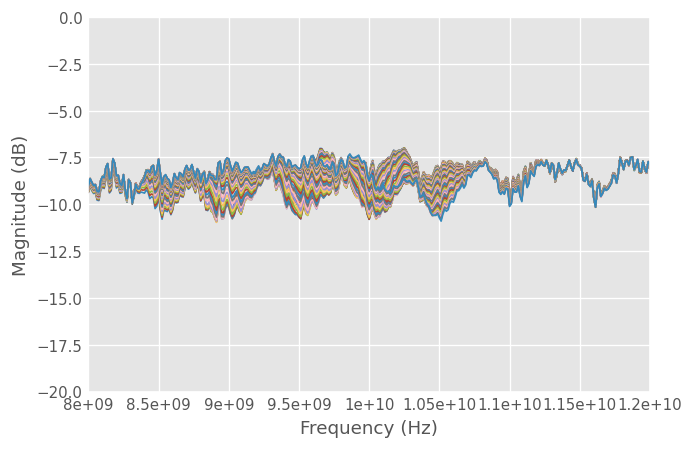

In [15]:
for i in range(ts.shape[1]):
    measurements_corrected[i].s21.plot_s_db(show_legend=False)
plt.xlim(8E9, 12E9)
plt.ylim(-20, 0)
plt.show()

### Save measurement

In [16]:
data_folder = 'C:/Users/smithlab/Documents/Aaron/Data/Aaron Quick Turn Antenna/Assembled_Board_1_22-01-27/'

today = date.today()
date_str = today.strftime("%Y-%m-%d")

measurement_name = 'Test_Element'

rf.write(data_folder + measurement_name + '_' + date_str + '.ntwk', measurements)
rf.write(data_folder + measurement_name + '_' + date_str + '_calibrated' + '.ntwk', measurements_corrected)